# Taxon definition and lineage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from paraspec.base import IR12SpeciationModel, DD03SpeciationModel
import paraspec.taxon_lineage as txl

## Functions to compute and visualize speciation model

In [2]:
def run_model(trait_comp=False, num_gen=100, pop_size = 10):
    length = (250, 250)
    spacing = (1, 1)
    X, Y = np.meshgrid(*[np.arange(0, l + s, s) for l, s in zip(length, spacing)])
    r = np.random.RandomState(0)
    elevation = X + r.rand(*Y.shape)
    environment = np.stack([elevation])
    if trait_comp:
        model = DD03SpeciationModel(X, Y, pop_size, birth_rate=1, movement_rate=5, 
                                 slope_trait_env= [0.95],
                                 car_cap_max=250, sigma_env_trait=0.2, 
                                 mut_prob=0.05, sigma_mut=0.05, sigma_mov=5, sigma_comp_trait=0.9, 
                                 sigma_comp_dist=0.1, random_seed=1234)
    else:
        model = IR12SpeciationModel(X, Y, pop_size,nb_radius=50, car_cap=25,
                                 slope_trait_env = [0.95, -0.95],
                                 sigma_env_trait=0.2, sigma_mov=5, sigma_mut=0.05,
                                 mut_prob=0.05, random_seed=1234)

    model.initialize([[0.5, 0.5]])
    dfs = []
    for step in range(num_gen):
        model.evaluate_fitness(environment, [elevation.min()], [elevation.max()], 1)
        dfs.append(model.to_dataframe())
        model.update_individuals(1)
    return pd.concat(dfs).reset_index(drop=True), elevation, X

In [3]:
def plot_sol(dtf, elevation, X):
    num_gen = dtf.step.unique().size
    fig1, axs1 = plt.subplots(2, 2, sharex="col", figsize=(12, 6))
    axs1[0,0].plot(dtf.groupby('step').size())
    h,xedge,yedge,_=axs1[1,0].hist2d(x=dtf['step'], y=dtf['trait_0'],
                                     range=((0, num_gen), (0, 1)),
                                     bins=(num_gen, 100), cmap='bone_r')
    axs1[0, 1].pcolormesh(elevation)
    axs1[0, 1].scatter(dtf['x'].loc[dtf['step']==max(dtf['step'])],
                       dtf['y'].loc[dtf['step']==max(dtf['step'])],
                       c=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                       edgecolor='w',vmin=0, vmax=1)
    h,xedge,yedge,_=axs1[1,1].hist2d(x=dtf['x'].loc[dtf['step']==max(dtf['step'])],
                                     y=dtf['trait_0'].loc[dtf['step']==max(dtf['step'])],
                                     range=((0, X.max()), (0, 1)),
                                     bins=(25, 250), cmap='bone_r')
    axs1[0, 1].yaxis.set_label_position("right")
    axs1[0, 1].yaxis.tick_right()
    axs1[1, 1].yaxis.set_label_position("right")
    axs1[1, 1].yaxis.tick_right()
    axs1[0, 1].set_ylabel('Y', weight='bold')
    axs1[0, 0].set_ylabel('Abundance (No. ind)', weight='bold')
    axs1[1, 1].set_ylabel('Trait', weight='bold')
    axs1[1, 0].set_ylabel('Trait', weight='bold')
    axs1[1, 1].set_xlabel('X', weight='bold')
    axs1[1, 0].set_xlabel('Time (generations)', weight='bold')

## Phylogeny for a speciation model without trait-mediated competition

In [4]:
ind_dtf1, elevation1, X1 = run_model(trait_comp=False)

In [5]:
ind_dtf1

,step,time,dt,id,x,y,taxon_id,ancestor_id,n_offspring,fitness,trait_0
0,0,0.0,0.0,0,110.251531,15.034664,1,0,24,0.962103,0.500000
1,0,0.0,0.0,1,152.467702,170.922227,1,0,22,0.880864,0.500000
2,0,0.0,0.0,2,215.905324,167.809505,1,0,3,0.224561,0.500000
3,0,0.0,0.0,3,215.939418,152.754495,1,0,3,0.227340,0.500000
4,0,0.0,0.0,4,168.720328,15.034328,1,0,18,0.703322,0.500000
...,...,...,...,...,...,...,...,...,...,...,...
16730,99,99.0,0.0,16730,146.994703,31.684154,561,557,1,0.999673,0.589933
16731,99,99.0,0.0,16731,153.727381,8.753053,561,557,1,0.995934,0.589933
16732,99,99.0,0.0,16732,149.373203,9.026281,561,557,1,0.910127,0.676519
16733,99,99.0,0.0,16733,171.486265,16.738785,561,557,1,0.917312,0.589933


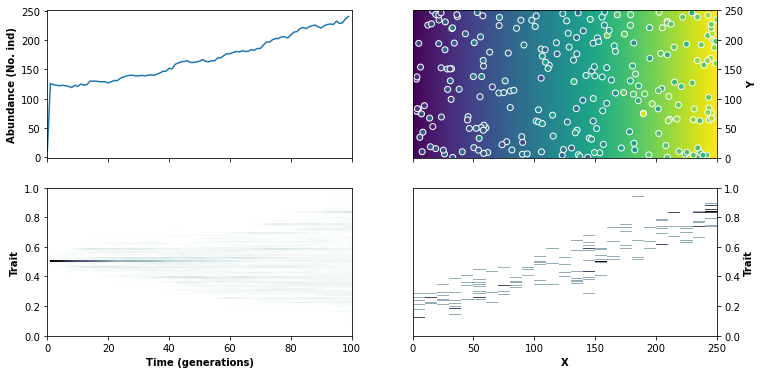

In [6]:
plot_sol(ind_dtf1, elevation1, X1)

In [7]:
#dtf_out1 = txl.taxon_definition(ind_dtf1)
#dtf_out1

In [8]:
taxon_lineage1 = txl.dtf_taxon(ind_dtf1)
taxon_lineage1

,time,id,parent,trait_0,abundance,node_type,branch_length
0,0.0,1,0,0.500000,10,root,0.001
1,1.0,2,1,0.500787,126,node,1.001
2,2.0,3,2,0.501113,124,node,1.001
3,3.0,4,3,0.501944,123,node,1.001
4,4.0,5,4,0.502086,122,node,1.001
...,...,...,...,...,...,...,...
569,99.0,570,549,0.846480,13,leaf,0.001
570,99.0,571,550,0.711166,16,leaf,0.001
571,99.0,572,551,0.215365,14,leaf,0.001
572,99.0,573,552,0.486060,5,leaf,0.001


(-1680.0900000000001, 17992.09, -1826.6400000000003, 19430.640000000003)

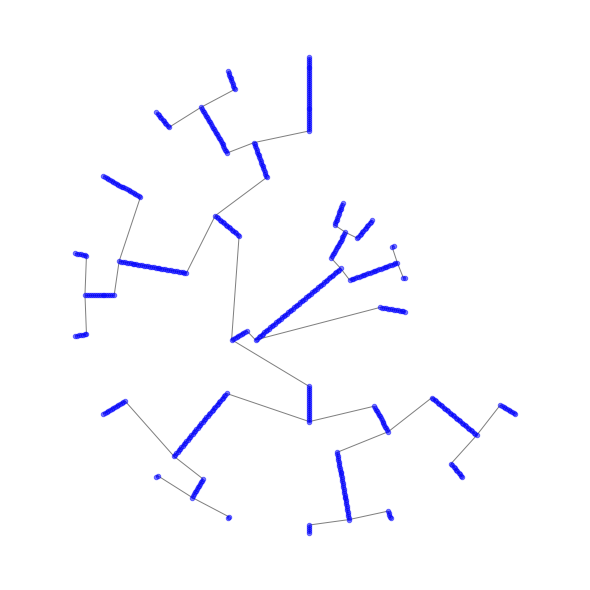

In [9]:
G = (taxon_lineage1
     .ptree.to_networkx(node_col='trait_0'))

pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, node_size=20, alpha=0.5, node_color="blue")
plt.axis("equal")

In [10]:
tree1 = txl.pandas_dtf_to_dendropy_tree(taxon_lineage1)

In [11]:
tree1.as_string(schema='newick')

'(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((570:0.001)node:0.001,(571:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001,((((((((((((((((((((((((((((560:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:0.001,((((((((((((561:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:0.001)node:0.001)node:1.001)node:

In [12]:
tree1.print_plot()

                                                                         /+ 570
                                                     +++++++++++++++++++++     
                                                     |                   \+ 571
         /++++++++++++++++++++++++++++++++++++++++++++                         
         |                                           |           ++++++++++ 560
         |                                           +++++++++++++             
         |                                                       ++++++++++ 561
         |                                                                     
         |                                   /+++++++++++++++++++++++++++++ 567
         |                    /+++++++++++++++                                 
++++++++++                    |              |                    /++++++++ 569
         |                    |              \+++++++++++++++++++++            
         |       /+++++++++++++         

## Phylogeny for a speciation model with trait-mediated competition

In [13]:
ind_dtf2, elevation2, X2 = run_model(trait_comp=True)

In [14]:
ind_dtf2

,step,time,dt,id,x,y,taxon_id,ancestor_id,n_offspring,events_i,death_i,trait_0
0,0,0.0,0.0,0,110.251531,15.034664,1,0,1,M,0.071978,0.500000
1,0,0.0,0.0,1,152.467702,170.922227,1,0,1,M,0.079846,0.500000
2,0,0.0,0.0,2,215.905324,167.809505,1,0,1,M,0.540020,0.500000
3,0,0.0,0.0,3,215.939418,152.754495,1,0,1,M,0.550750,0.500000
4,0,0.0,0.0,4,168.720328,15.034328,1,0,2,B,0.098603,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
8029,99,99.0,1.0,1135,154.584867,229.845438,143,135,0,D,0.917388,0.500000
8030,99,99.0,1.0,1136,103.225566,181.692157,141,136,1,M,1.114898,0.500000
8031,99,99.0,1.0,1137,136.464333,84.327033,140,138,1,M,0.682746,0.500000
8032,99,99.0,1.0,1138,136.125925,229.575927,140,138,2,B,0.941348,0.500000


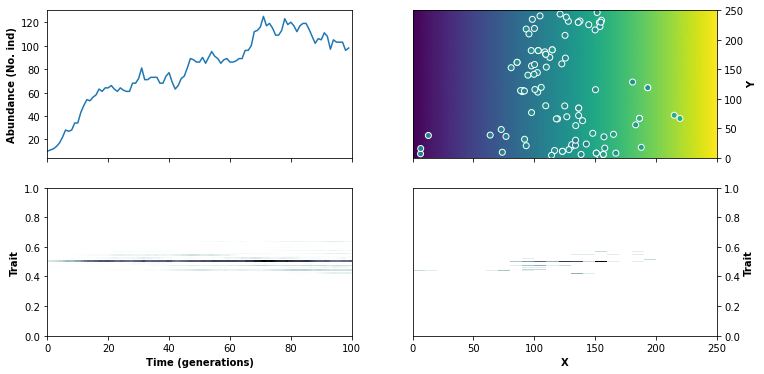

In [15]:
plot_sol(ind_dtf2, elevation2, X2)

In [16]:
#dtf_out2 = txl.taxon_definition(ind_dtf2.drop(columns=['taxon_id','ancestor_id']))
#dtf_out2

In [17]:
taxon_lineage2 = txl.dtf_taxon(ind_dtf2)
taxon_lineage2

,time,id,parent,trait_0,abundance,node_type,branch_length
0,0.0,1,0,0.500000,10,root,0.001
1,1.0,2,1,0.500000,11,node,1.001
2,2.0,3,2,0.500000,12,node,1.001
3,3.0,4,3,0.500000,14,node,1.001
4,4.0,5,4,0.500000,17,node,1.001
...,...,...,...,...,...,...,...
138,99.0,139,137,0.486703,2,leaf,1.001
139,99.0,140,138,0.509927,16,leaf,0.001
140,99.0,141,136,0.496389,51,leaf,0.001
141,99.0,142,134,0.487135,14,leaf,0.001


(-627.7170000000001, 6917.117, -738.0, 7974.0)

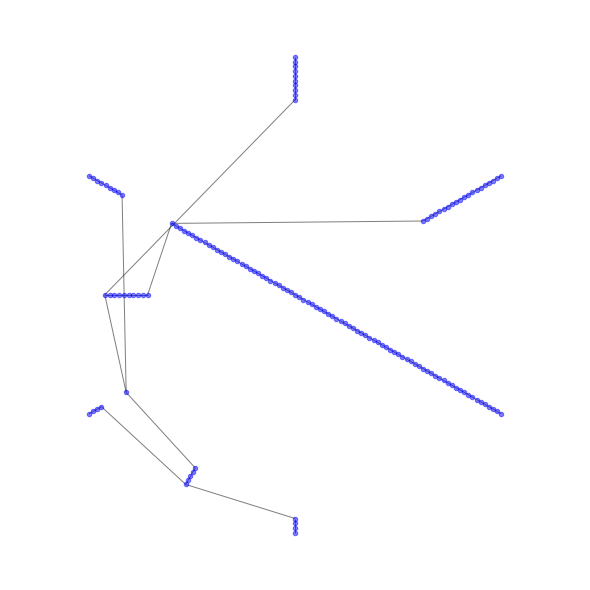

In [18]:
G = (taxon_lineage2
     .ptree.to_networkx(node_col='trait_0'))

pos = nx.nx_agraph.graphviz_layout(G, prog="twopi", args="")
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, node_size=20, alpha=0.5, node_color="blue")
plt.axis("equal")

In [19]:
tree2 = txl.pandas_dtf_to_dendropy_tree(taxon_lineage2)

In [20]:
tree2.as_string(schema='newick')

'(((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((139:1.001)node:0.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:0.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001,(((((((((((((((((((140:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001,(((((((((142:0.001)node:1.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001,((((((((143:0.001)node:0.001)node:0.001)node:0.001,(((141:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:0.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.001)node:1.0

In [21]:
tree2.print_plot()

                                                           /+++++++++++++++ 139
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++                   
                                                           |       /+++++++ 140
                                                           \++++++++           
                                                                   |+++++++ 142
                                                                   \+          
                                                                    |  /+++ 143
                                                                    ++++       
                                                                       \+++ 141
                                                                               
                                                                               
